### Linear Regression the MCMC Bayesian Way


This is a simple notebook demonstrating to fitting Bayesian Linear Regression with MCMC in TFP. We assume the following model.

$$
    y \thicksim N(a \cdot x + b, \sigma^2=1)
$$
The priors are
$$
    a \thicksim N(0,1) \\
    b \thicksim N(0,1)
$$

So, we assume that we know the noise $\sigma^2=1$ of the data. We can drop this assumption later, however, here we want to show the different ways to fit Bayesian models and we can only visualize 2D Data. As a side note: estimating $\sigma$ is a bit more complicated, since we cannot assume a Gaussian prior.

We use the same dataset as in nb_ch08_01 in https://tensorchiefs.github.io/dl_book/, where the analytical solution and the variational approach is shown. 

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.8.0
TF  Version 2.0.0


In [29]:
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

### Creation of data

Creation of some data

$$
    p(y|x) = N(a \cdot x + b, \sigma^2=1) \; \; \text{with } a=1 \text{ and } b=-1
$$  


In [30]:
np.random.seed(2)
num = 4
nbins = 10
bmin=-5;bmax=2
amin=1;amax=6
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=3
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,3,num) 

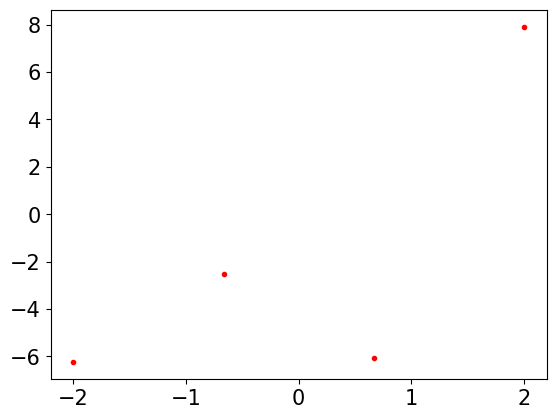

In [31]:
def createData(save=False):
    plt.scatter(x,y, marker='.', color='r')
    #print("x ", x.shape, "  ", y.shape)
    if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     
    return (x,y)
x,y = createData()

### Fitting a linear model (Max Likelihood)
First fit a linear model (corresponding to the maximum likelihood approach)

In [32]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)

Coefficients a_ml:  2.9205102572725816 Coefficients b_ml -1.726712471421449


## Bayesian linear regression


### Bayesian Formula (unnormalized Posterior)

$$
    P(w|D) = \frac{P(D|w) P(w)}{P(D)} =  \frac{P(D|w) P(w)}{\int P(D|w) P(w) dw} \thicksim P(D|w) P(w)
$$

We can calculate $P(D|w) P(w) =: \tt{unnormalized{\_}posterior}$ quite easily. For convenience and the later use in the TFP optimization framework, we must calculate the log the unnormalized posterior. Therefore, the relevant quantity is:

$$
    \log(P(D|w)) \thicksim \log(P(D|w)) + \log(P(w))
$$

For later use this function must only have one argument, the parameters or weights `w` of the model.  

In [33]:
ytensor = y.reshape([len(y),1])

def unnormalized_posterior(w): 
    rv_a = tfd.Normal(loc=0., scale=1.) #This is the prior for the slope and
    rv_b = tfd.Normal(loc=0., scale=1.) #intercept.    
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=1.0), reinterpreted_batch_ndims=1)
    return (
         tf.reduce_sum(
             rv_a.log_prob(w[0])+ 
             rv_b.log_prob(w[1])+
             tf.reduce_sum(y_prob.log_prob(ytensor))) 
    )

## Maximum A-Posterior

Before, we draw samples from the posterior $𝑃(𝑤|𝐷)$ we calculate the Maximum Posterior Solution.

In [34]:
w = tf.Variable([[1.0],[2.0]],dtype=tf.float32)
for e in range(300):
    with tf.GradientTape() as tape: 
        loss = -unnormalized_posterior(w)
        grads = tape.gradient(loss, w)
        w = tf.Variable(w - 0.01*grads)
a_max_post = w[0].numpy()[0]
b_max_post = w[1].numpy()[0]
print("Maximum A-Posterior a", a_max_post, " b ", b_max_post)

Maximum A-Posterior a 2.6251767  b  -1.3813689


## Using MCMC

In the MCMC method you start at a certain value (a and b). Then you step to nearby values (a' and b') if the probability for the nearby value is higher, you accept it. If not you you accept if with the probability $P((a',b')|D)/P((a,b)|D)$. The great thing is that just need the unormalized probability in that case. So we jump from state to state and simply count how often we are in the state.

### Metropolis 

The easiest MCMC-algorithm is random walk metropolis. This is included in TensorFlow probability.

In [51]:
#The sampler
#metropolis=tfp.mcmc.RandomWalkMetropolis(unnormalized_posterior,seed=42)
metropolis=tfp.mcmc.NoUTurnSampler(unnormalized_posterior, step_size=0.1)
burn_in = 10 
#metropolis=tfp.mcmc.HamiltonianMonteCarlo(unnormalized_posterior, 
#                                          step_size=0.1, 
#                                          num_leapfrog_steps=40)

start = time.time() 
#Does create a chain of samples
states, kernel_results = tfp.mcmc.sample_chain(
        num_results=100,
        current_state = tf.Variable([[5],[-5]],dtype=tf.float32),
        kernel=metropolis)
print(time.time() - start, " seconds")

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


16.99532914161682  seconds


Text(0, 0.5, 'Sampled values of a / b')

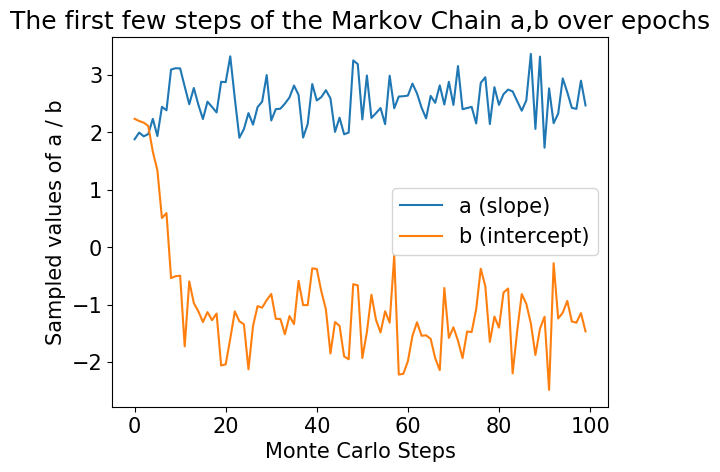

In [52]:
plt.plot(states[:,0])
plt.plot(states[:,1])
plt.legend(('a (slope)','b (intercept)'))
plt.title("The first few steps of the Markov Chain a,b over epochs")
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Sampled values of a / b')

Text(0, 0.5, 'b intercept')

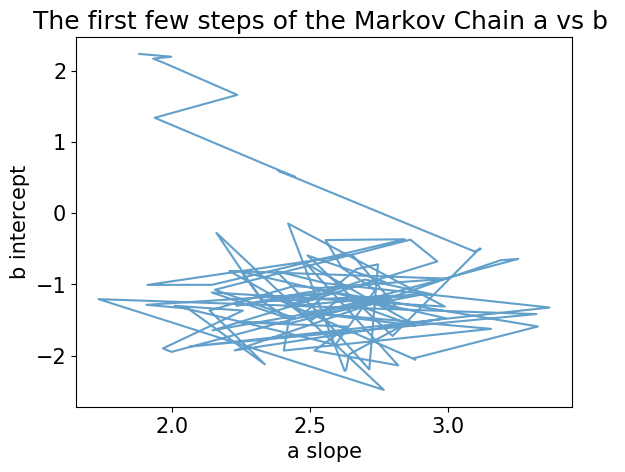

In [54]:
import pandas as pd
df=pd.DataFrame({'xvalues': states[0:,0,0], 'yvalues': states[0:,1,0] })
plt.title("The first few steps of the Markov Chain a vs b ")
plt.plot('xvalues', 'yvalues', data=df, alpha=0.7) #third argument, it could be several chains
plt.xlabel('a slope')
plt.ylabel('b intercept')

How often a chain visits a certain value (combination a,b) is proportional to the posterior probability $P((a,b)|d)$ 
You see the chain is often at regions with hight probability. Around $a=1$ and $b=-1$

slope 0.6278135776519775  std 2.092836856842041
inter 0.6278135776519775  std 2.092836856842041


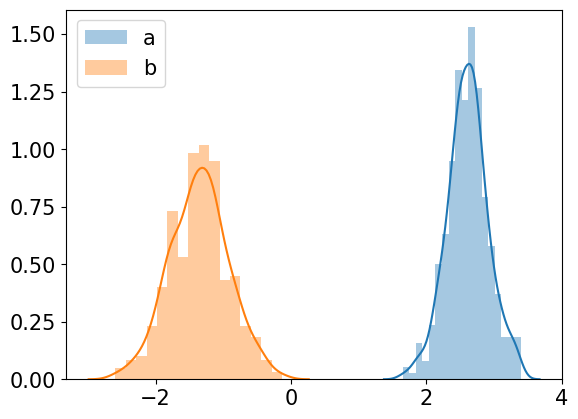

In [67]:
sns.distplot(states[burn_in:,0], norm_hist=True, kde=True)
sns.distplot(states[burn_in:,1], norm_hist=True, kde=True)
plt.legend(('a','b'))
print("slope {}  std {}".format(np.mean(states[burn_in:]), np.std(states)))
print("inter {}  std {}".format(np.mean(states[burn_in:]), np.std(states)))

### Make it faster

For a better statistic we want to have more samples, we increase the number of results. To be fast, we compile the calculations into a TensorFlow function.

In [56]:
import time
start = time.time()
w = current_state = tf.Variable([[5],[-5]],dtype=tf.float32)
@tf.function #Much faster, when compiling
def run_chain():
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=400,
        current_state = w,
        kernel=metropolis)
    return(states, kernel_results)
states, kernel_results = run_chain()
print(time.time() - start, " seconds")

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


3.110643148422241  seconds


Actually we have 2-D density and should reflect this fact in the plot. There can be correlations between the variables. Let's look at the covariance matrix.

In [57]:
cov_mcmc = np.cov(np.transpose(states[200:,:,0]))
cov_mcmc

array([[ 0.09997799, -0.02566618],
       [-0.02566618,  0.19232947]])

slope 2.560520648956299  std 0.3161929684289652
inter -1.405362606048584  std 0.4385538382190683


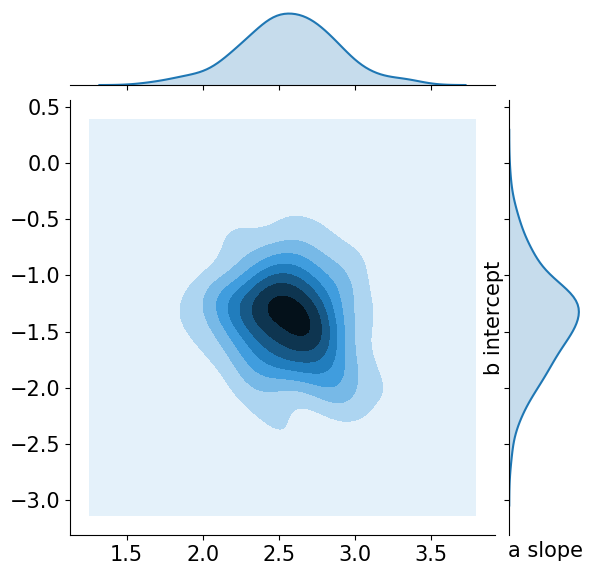

In [58]:
sns.jointplot(x=states[200:,0], y=states[200:,1], kind='kde')

plt.xlabel('a slope')
plt.ylabel('b intercept')
a_locmcmc = np.mean(states[200:,0])
b_locmcmc = np.mean(states[200:,1])
print("slope {}  std {}".format(a_locmcmc, np.sqrt(cov_mcmc[0,0])))
print("inter {}  std {}".format(b_locmcmc, np.sqrt(cov_mcmc[1,1])))

### Probabilistic Model Definition with Edward
The definition of the model has been done using the function `unnormalized_posterior`. Alternatively one can specify a model using the Edward Language. 

#### Defining the model using Edward

Here we define the models generative process. Using the Distributions provided in Edward2. The Syntax seems to be:

* input the data value x
* variables with names. These names are later used to feed in the variables from the MCMC runs. **They do matter**

In [60]:
def linear_regression(x):
  """
      features is a list containing []
  """
  D = x.shape[1]      # number of dimensions
  a_ed = ed.Normal(         # normal prior on weights
      loc=tf.zeros([D,1], dtype=tf.float32),
      scale=tf.ones([D,1], dtype=tf.float32),
      name="coeffs")   #<--- The name of these variables is important
  b_ed = ed.Normal(          # normal prior on bias
      loc=tf.zeros([1], dtype=tf.float32), 
      scale=tf.ones([1], dtype=tf.float32),
      name="bias") 
# We have fixed the noise here
#   noise_std = ed.HalfNormal( # half-normal prior on noise std
#       scale=tf.ones([1]),
#       name="noise_std")
  predictions = ed.Normal(   # normally-distributed noise
      loc=tf.matmul(x, a_ed)+b_ed,
      scale=tf.ones([1], dtype=tf.float32),
      name="predictions")
  return predictions

In [61]:
from tensorflow_probability import edward2 as ed
# Joint posterior distribution
log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, bias):
  return log_joint(
      x=np.array(x,dtype='float32'),
      coeffs=coeffs, #<-- This has to have the same name as above 
      bias=bias,
      predictions=y.reshape([len(y),1]))

tf.Variable([[5],[-5]],dtype=tf.float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 5.],
       [-5.]], dtype=float32)>

In [66]:
#The sampler
sampler_ed=tfp.mcmc.NoUTurnSampler(target_log_prob_fn=target_log_prob_fn,step_size=0.1)


D = 1
coeffs_size = [D,1]
bias_size = [1]
current_state=[
        tf.zeros(coeffs_size, name='init_coeffs', dtype=tf.float32),
        tf.zeros(bias_size, name='init_bias',dtype=tf.float32)
    ]

#Does create a chain of samples
states_ed, kernel_results_ed = tfp.mcmc.sample_chain(
        num_results=100,
        current_state =current_state,
        kernel=sampler_ed)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


slope 2.642178773880005  std 0.3371131122112274
inter -1.4051679372787476  std 0.44337350130081177


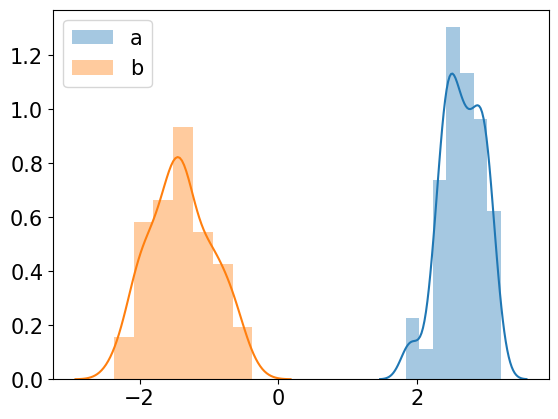

In [91]:
se0 = states_ed[0].numpy().flatten()
se1 = states_ed[1].numpy().flatten()
sns.distplot(se0[burn_in:], norm_hist=True, kde=True)
sns.distplot(se1[burn_in:,], norm_hist=True, kde=True)
plt.legend(('a','b'))
print("slope {}  std {}".format(np.mean(se0[burn_in:]), np.std(se0)))
print("inter {}  std {}".format(np.mean(se1[burn_in:]), np.std(se1)))

Maybe I don't understand Edward. It looks too complicated. It's easier to define the unnormalized_posterior directly. If you are looking for a high-level language Stan looks much simpler. Here the model definition in Stan

```
data{
   int<lower=0> N;
   vector[N] y;
   vector[N] x;
}
 
parameters{
   real a; 
   #Here we have the possibility of constrains 
   #real<lower=0> a;
   real b;
}
 
model{
  y ~ normal(a * x + b, 1); 
  a ~ normal(0, 1); #Prior for a
  b ~ normal(0, 1); #Prior for b
}
```